<a href="https://colab.research.google.com/github/countingtls/PA_HRV_Sleep/blob/main/PA_test_14_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import sklearn.pipeline
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install hrv_analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Read in the dataset

df_test = pd.read_csv("/content/drive/MyDrive/SWELL/hrv dataset/data/final/test.csv")
df_train = pd.read_csv("/content/drive/MyDrive/SWELL/hrv dataset/data/final/train.csv")
print(f"df_train shape{df_train.shape}")
print(f"df_test shape{df_test.shape}")

df_train shape(369289, 36)
df_test shape(41033, 36)


In [ ]:
df_PA_all = pd.read_csv("/content/drive/MyDrive/SWELL/hrv PA/PA_all_p.csv")
print(f"df_PA_all shape{df_PA_all.shape}")

df_PA_all shape(37026, 18)


In [ ]:
df_PA_cat = pd.read_csv("/content/drive/MyDrive/SWELL/hrv PA/PA_category_dictionary.csv", header=None, index_col=0, squeeze=True)
df_PA_dict = pd.read_csv("/content/drive/MyDrive/SWELL/hrv PA/PA_category_dictionary_int.csv", header=None, index_col=0, squeeze=True)
print(f"df_PA_dict shape{df_PA_dict.shape}")
print(f"df_PA_cat shape{df_PA_cat.shape}")

df_PA_dict shape(215,)
df_PA_cat shape(215,)


In [ ]:
p1_raw = pd.read_csv("/content/drive/MyDrive/SWELL/hrv dataset/data/raw/rri/p1.txt", sep=None, engine='python', 
header=None, quoting=0, skipinitialspace=True)
print(f"p1_raw{p1_raw.shape}")

p1_raw(35974, 2)


In [ ]:
display(p1_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35974 entries, 0 to 35973
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       35974 non-null  float64
 1   1       35974 non-null  float64
dtypes: float64(2)
memory usage: 562.2 KB


None

In [ ]:
hrv_window_in_min = 5
hrv_window_in_sec = hrv_window_in_min * 60
sampling_rate_hz = 4
hrv_window_samples = hrv_window_in_sec * sampling_rate_hz
m = hrv_window_samples 
t1=p1_raw.iloc[0:m-1,1].values

In [ ]:
from hrvanalysis import *
rr_intervals_without_outliers = remove_outliers(rr_intervals=t1, low_rri=300, high_rri=2000)
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
                                                   interpolation_method="linear")
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
t1_nni = interpolated_nn_intervals

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.


In [ ]:
t1_time_domain_features = get_time_domain_features(t1_nni)
t1_frequency_domain_features = get_frequency_domain_features(t1_nni)
t1_geometrical_features = get_geometrical_features(t1_nni)
t1_poincare_plot_features = get_poincare_plot_features(t1_nni)
t1_csi_cvi_featuress = get_csi_cvi_features(t1_nni)
t1_sampen = get_sampen(t1_nni)
print(t1_time_domain_features)
print(t1_frequency_domain_features)
print(t1_geometrical_features)
print(t1_poincare_plot_features)
print(t1_csi_cvi_featuress)
print(t1_sampen)

{'mean_nni': 932.1795375479568, 'sdnn': 131.44268945640002, 'sdsd': 13.61806603470211, 'nni_50': 4, 'pnni_50': 0.333889816360601, 'nni_20': 155, 'pnni_20': 12.93823038397329, 'rmssd': 13.618171445401018, 'median_nni': 966.36998, 'range_nni': 657.66723, 'cvsd': 0.014608957713470962, 'cvnni': 0.14100576569418402, 'mean_hr': 65.99109917173085, 'max_hr': 113.2847796026676, 'min_hr': 50.53457579887373, 'std_hr': 11.767116979417475}
{'lf': 1203.1308721280757, 'hf': 5.006709739241741, 'lf_hf_ratio': 240.30369939326425, 'lfnu': 99.58558447196855, 'hfnu': 0.4144155280314421, 'total_power': 3768.7890349625077, 'vlf': 2560.6514530951904}
{'triangular_index': 23.50980392156863, 'tinn': None}
{'sd1': 9.633448317027561, 'sd2': 185.63824470347265, 'ratio_sd2_sd1': 19.27017601530581}
{'csi': 19.27017601530581, 'cvi': 4.456569207719794, 'Modified_csi': 14309.126602433318}
{'sampen': 0.355685151443028}


In [ ]:
df_train.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,no stress
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,interruption
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,interruption
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,no stress
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,no stress


In [ ]:
df_PA_all.head()

,MEAN_RR,SDRR,HR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,PA,ID,categories,device_time
0,580.0,25.0,103.448276,0.0,0.000000,173.0,80.092593,90.104167,19.0,8.796296,9.895833,216.0,9.105263,0.109827,on patch,1,-1,2016-01-07 08:27:41
1,611.0,43.0,98.199673,1286.0,56.852343,913.0,40.362511,95.802728,40.0,1.768347,4.197272,2262.0,22.825000,0.043812,breakfast,1,-1,2016-01-07 08:28:00
2,633.0,54.0,94.786730,674.0,29.665493,1410.0,62.059859,90.967742,140.0,6.161972,9.032258,2272.0,10.071429,0.099291,breakfast,1,-1,2016-01-07 08:28:38
3,649.0,49.0,92.449923,1142.0,70.147420,379.0,23.280098,88.139535,51.0,3.132678,11.860465,1628.0,7.431373,0.134565,breakfast,1,-1,2016-01-07 08:29:53
4,635.0,54.0,94.488189,1337.0,61.955514,605.0,28.035218,81.208054,140.0,6.487488,18.791946,2158.0,4.321429,0.231405,breakfast,1,-1,2016-01-07 08:32:23


In [ ]:
df_train['condition'].unique()

array(['no stress', 'interruption', 'time pressure'], dtype=object)

In [ ]:
df_PA_all['PA'].unique()

array(['on patch', 'breakfast', 'commuting-riding motor', nan,
       'after up 6 floors', 'work-desk', 'lunch', 'work-discussion',
       'work-meeting', 'arrive home', 'dinner', 'pre-sleep satus',
       'go to bed & light off', 'sleep', 'off patch since itch',
       'on patch at 40 min after swimming 1 hour-long', 'watch TV',
       'go to bed', 'sleep (wake to watch the clock)', 'get up',
       'off patch ', 'after swimming and showering', 'commuting-motor',
       'dining', 'commuting-MRT', 'arrive office', 'sleeping',
       '20 mins after home workout', 'chating ', 'discussion',
       'meeting in English', 'dining+discussion',
       '20 mins after swimming 1 hour', 'chatting', 'commuting',
       'lunch break', 'taking MRT', 'dining ', 'relaxing', 'GO TO BED',
       'GET UP', 'morning preparation', 'warm up for run',
       'running (HR is not correct)', '45 min after running 10 km',
       'prepare go out', 'to go upstairs', 'desk work', 'coffeex1',
       'prepare meeting

In [ ]:
PA_unique_counts = df_PA_all['PA'].value_counts(dropna=False)
print(PA_unique_counts)
pd.DataFrame(PA_unique_counts).to_csv("/content/drive/MyDrive/SWELL/hrv PA/PA_uniquie_counts.csv")

sleeping                           8343
leisure time-home                  3481
walking                            2621
work-desk                          2323
desk working                       2230
                                   ... 
 go to bed                            1
Get up S0L>5,WASO>5,NOA=0,SSQ=7       1
Get up S0L>5,WASO>5,NOA=0,SSQ=8       1
coffeex1                              1
6:38-8:40 gym workout                 1
Name: PA, Length: 215, dtype: int64


In [ ]:
PA_dict=df_PA_dict.to_dict()
print(PA_dict)

{'work-desk': 5, 'desk working': 5, 'working': 5, 'work-meeting': 5, 'study': 5, 'work-discussion': 5, 'meeting': 5, 'discussion': 5, 'READING': 5, 'reading paper': 5, 'reading ': 5, 'meeting+discussion': 5, 'studing': 5, 'desk work': 5, 'working ': 5, 'surfing the internet': 5, 'writing': 5, 'BROWSING': 5, 'browsing': 5, 'working in lab': 5, 'studying': 5, 'meeting+discussing': 5, 'MEETING ': 5, 'meeting in English': 5, 'data manage': 5, 'text line': 5, 'text email': 5, 'dealing with patch data': 5, 'work chores': 5, 'text for work': 5, 'discussion with frustrated': 5, 'prepare meeting': 5, 'study ': 5, 'sleeping': 4, 'sleep': 4, 'napping': 4, 'Sleeping': 4, 'Sleep': 4, 'SLEEP': 4, 'fall asleep': 4, 'awake': 4, 'GO TO BED': 4, 'pre-sleep status': 4, 'go to bed': 4, 'GET UP': 4, 'get up': 4, 'GETUP': 4, 'light sleep': 4, 'pre-sleep': 4, 'pre-sleep satus': 4, 'Go to bed DF=8': 4, 'presleep status': 4, 'go to bed & light off': 4, 'sleep (wake to watch the clock)': 4, 'wake up by clock': 

In [ ]:
PA_cat_dict=df_PA_cat.to_dict()
print(PA_cat_dict)

{'work-desk': '{Working}', 'desk working': '{Working}', 'working': '{Working}', 'work-meeting': '{Working}', 'study': '{Working}', 'work-discussion': '{Working}', 'meeting': '{Working}', 'discussion': '{Working}', 'READING': '{Working}', 'reading paper': '{Working}', 'reading ': '{Working}', 'meeting+discussion': '{Working}', 'studing': '{Working}', 'desk work': '{Working}', 'working ': '{Working}', 'surfing the internet': '{Working}', 'writing': '{Working}', 'BROWSING': '{Working}', 'browsing': '{Working}', 'working in lab': '{Working}', 'studying': '{Working}', 'meeting+discussing': '{Working}', 'MEETING ': '{Working}', 'meeting in English': '{Working}', 'data manage': '{Working}', 'text line': '{Working}', 'text email': '{Working}', 'dealing with patch data': '{Working}', 'work chores': '{Working}', 'text for work': '{Working}', 'discussion with frustrated': '{Working}', 'prepare meeting': '{Working}', 'study ': '{Working}', 'sleeping': '{Sleep}', 'sleep': '{Sleep}', 'napping': '{Sl

In [ ]:
df_PA_all_cat = df_PA_all
df_PA_all_cat['categories'] = df_PA_all['PA'].map(PA_cat_dict, na_action=None)
pd.DataFrame(df_PA_all_cat).to_csv("/content/drive/MyDrive/SWELL/hrv PA/PA_all_with_categories.csv")

In [ ]:
df_PA_all_int = df_PA_all
df_PA_all_int['categories'] = df_PA_all['PA'].map(PA_dict, na_action=None)
df_PA_all_int.head(20)

,MEAN_RR,SDRR,HR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,PA,ID,categories,device_time
0,580.0,25.0,103.448276,0.0,0.000000,173.0,80.092593,90.104167,19.0,8.796296,9.895833,216.0,9.105263,0.109827,on patch,1,-1,2016-01-07 08:27:41
1,611.0,43.0,98.199673,1286.0,56.852343,913.0,40.362511,95.802728,40.0,1.768347,4.197272,2262.0,22.825000,0.043812,breakfast,1,1,2016-01-07 08:28:00
2,633.0,54.0,94.786730,674.0,29.665493,1410.0,62.059859,90.967742,140.0,6.161972,9.032258,2272.0,10.071429,0.099291,breakfast,1,1,2016-01-07 08:28:38
3,649.0,49.0,92.449923,1142.0,70.147420,379.0,23.280098,88.139535,51.0,3.132678,11.860465,1628.0,7.431373,0.134565,breakfast,1,1,2016-01-07 08:29:53
4,635.0,54.0,94.488189,1337.0,61.955514,605.0,28.035218,81.208054,140.0,6.487488,18.791946,2158.0,4.321429,0.231405,breakfast,1,1,2016-01-07 08:32:23
5,602.0,50.0,99.667774,1394.0,80.253310,290.0,16.695452,90.062112,32.0,1.842257,9.937888,1737.0,9.062500,0.110345,breakfast,1,1,2016-01-07 08:34:53
6,600.0,37.0,100.000000,1078.0,78.801170,188.0,13.742690,70.943396,77.0,5.628655,29.056604,1368.0,2.441558,0.409574,breakfast,1,1,2016-01-07 08:37:23
7,612.0,34.0,98.039216,709.0,71.833840,226.0,22.897670,88.976378,28.0,2.836879,11.023622,987.0,8.071429,0.123894,breakfast,1,1,2016-01-07 08:39:53
8,620.0,42.0,96.774194,695.0,42.121212,670.0,40.606061,75.112108,222.0,13.454545,24.887892,1650.0,3.018018,0.331343,commuting-riding motor,1,-1,2016-01-07 08:42:23
9,605.0,52.0,99.173554,1365.0,58.258643,749.0,31.967563,82.127193,163.0,6.956893,17.872807,2343.0,4.595092,0.217623,commuting-riding motor,1,-1,2016-01-07 08:44:53


In [ ]:
df_PA_all5_int = df_PA_all_int.loc[(df_PA_all_int['categories'] > 0)]

In [ ]:
df_PA_working_int = df_PA_all_int.loc[df_PA_all_int['categories'] == 5]

In [ ]:
#udf = df_PA_all['PA'].unique()
#udic=pd.DataFrame(udf).to_dict()
#fpd=pd.factorize(df_PA_all.PA)
#print(fpd)

In [ ]:
#check if there is any missing value in the datasets
display(df_train.info())
display(df_test.info())
display(df_PA_working_int.info())
display(df_PA_all5_int.info())
display(df_PA_all_int.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MEAN_RR            369289 non-null  float64
 1   MEDIAN_RR          369289 non-null  float64
 2   SDRR               369289 non-null  float64
 3   RMSSD              369289 non-null  float64
 4   SDSD               369289 non-null  float64
 5   SDRR_RMSSD         369289 non-null  float64
 6   HR                 369289 non-null  float64
 7   pNN25              369289 non-null  float64
 8   pNN50              369289 non-null  float64
 9   SD1                369289 non-null  float64
 10  SD2                369289 non-null  float64
 11  KURT               369289 non-null  float64
 12  SKEW               369289 non-null  float64
 13  MEAN_REL_RR        369289 non-null  float64
 14  MEDIAN_REL_RR      369289 non-null  float64
 15  SDRR_REL_RR        369289 non-null  float64
 16  RM

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41033 entries, 0 to 41032
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEAN_RR            41033 non-null  float64
 1   MEDIAN_RR          41033 non-null  float64
 2   SDRR               41033 non-null  float64
 3   RMSSD              41033 non-null  float64
 4   SDSD               41033 non-null  float64
 5   SDRR_RMSSD         41033 non-null  float64
 6   HR                 41033 non-null  float64
 7   pNN25              41033 non-null  float64
 8   pNN50              41033 non-null  float64
 9   SD1                41033 non-null  float64
 10  SD2                41033 non-null  float64
 11  KURT               41033 non-null  float64
 12  SKEW               41033 non-null  float64
 13  MEAN_REL_RR        41033 non-null  float64
 14  MEDIAN_REL_RR      41033 non-null  float64
 15  SDRR_REL_RR        41033 non-null  float64
 16  RMSSD_REL_RR       410

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10805 entries, 17 to 36693
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MEAN_RR      10805 non-null  float64
 1   SDRR         10805 non-null  float64
 2   HR           10805 non-null  float64
 3   VLF          10805 non-null  float64
 4   VLF_PCT      10805 non-null  float64
 5   LF           10805 non-null  float64
 6   LF_PCT       10805 non-null  float64
 7   LF_NU        10805 non-null  float64
 8   HF           10805 non-null  float64
 9   HF_PCT       10805 non-null  float64
 10  HF_NU        10805 non-null  float64
 11  TP           10805 non-null  float64
 12  LF_HF        10805 non-null  float64
 13  HF_LF        10805 non-null  float64
 14  PA           10805 non-null  object 
 15  ID           10805 non-null  int64  
 16  categories   10805 non-null  int64  
 17  device_time  10805 non-null  object 
dtypes: float64(14), int64(2), object(2)
memory us

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32751 entries, 1 to 37025
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MEAN_RR      32751 non-null  float64
 1   SDRR         32751 non-null  float64
 2   HR           32751 non-null  float64
 3   VLF          32751 non-null  float64
 4   VLF_PCT      32751 non-null  float64
 5   LF           32751 non-null  float64
 6   LF_PCT       32751 non-null  float64
 7   LF_NU        32751 non-null  float64
 8   HF           32751 non-null  float64
 9   HF_PCT       32751 non-null  float64
 10  HF_NU        32751 non-null  float64
 11  TP           32751 non-null  float64
 12  LF_HF        32751 non-null  float64
 13  HF_LF        32751 non-null  float64
 14  PA           32751 non-null  object 
 15  ID           32751 non-null  int64  
 16  categories   32751 non-null  int64  
 17  device_time  32751 non-null  object 
dtypes: float64(14), int64(2), object(2)
memory usa

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37026 entries, 0 to 37025
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MEAN_RR      37026 non-null  float64
 1   SDRR         37026 non-null  float64
 2   HR           37026 non-null  float64
 3   VLF          37026 non-null  float64
 4   VLF_PCT      37026 non-null  float64
 5   LF           37026 non-null  float64
 6   LF_PCT       37026 non-null  float64
 7   LF_NU        37026 non-null  float64
 8   HF           37026 non-null  float64
 9   HF_PCT       37026 non-null  float64
 10  HF_NU        37026 non-null  float64
 11  TP           37026 non-null  float64
 12  LF_HF        37026 non-null  float64
 13  HF_LF        37026 non-null  float64
 14  PA           35352 non-null  object 
 15  ID           37026 non-null  int64  
 16  categories   37026 non-null  int64  
 17  device_time  37026 non-null  object 
dtypes: float64(14), int64(2), object(2)
memory usa

None

In [ ]:
#encode the labels
df_train['condition'] = df_train['condition'].map({'no stress':0, 'interruption':1, 'time pressure':2})
df_test['condition'] = df_test['condition'].map({'no stress':0, 'interruption':1, 'time pressure':2})

In [ ]:
df_train.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,0
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,1
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,1
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,0
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,0


In [ ]:
df_PA_all5_int.head()

,MEAN_RR,SDRR,HR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,PA,ID,categories,device_time
1,611.0,43.0,98.199673,1286.0,56.852343,913.0,40.362511,95.802728,40.0,1.768347,4.197272,2262.0,22.825000,0.043812,breakfast,1,1,2016-01-07 08:28:00
2,633.0,54.0,94.786730,674.0,29.665493,1410.0,62.059859,90.967742,140.0,6.161972,9.032258,2272.0,10.071429,0.099291,breakfast,1,1,2016-01-07 08:28:38
3,649.0,49.0,92.449923,1142.0,70.147420,379.0,23.280098,88.139535,51.0,3.132678,11.860465,1628.0,7.431373,0.134565,breakfast,1,1,2016-01-07 08:29:53
4,635.0,54.0,94.488189,1337.0,61.955514,605.0,28.035218,81.208054,140.0,6.487488,18.791946,2158.0,4.321429,0.231405,breakfast,1,1,2016-01-07 08:32:23
5,602.0,50.0,99.667774,1394.0,80.253310,290.0,16.695452,90.062112,32.0,1.842257,9.937888,1737.0,9.062500,0.110345,breakfast,1,1,2016-01-07 08:34:53


In [ ]:
#df_train_split, df_test_split = train_test_split(df_test, test_size=0.1, random_state=None)

In [ ]:
#df_train_split, df_test_split = train_test_split(df_test, test_size=0.1, random_state=None)

In [ ]:
#Split the datasets into train and test
X_train, y_train, X_test, y_test = df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values, df_test.iloc[:, :-1].values, df_test.iloc[:,-1].values

In [ ]:
PA_train, PA_label, PA_ID, PA_cat, PA_dtime = df_PA_all.iloc[:, 0:14].values, df_PA_all.iloc[:, 14].values, df_PA_all.iloc[:, 15].values, df_PA_all.iloc[:, 16].values, df_PA_all.iloc[:, 17].values

In [ ]:
XPA_train, yPA_train, yPA_label, yPA_ID, yPA_dtime = df_PA_all5_int.iloc[:, 0:14].values, df_PA_all5_int.loc[:, "categories"].values, df_PA_all5_int.loc[:, "PA"].values, df_PA_all5_int.loc[:, "ID"].values, df_PA_all5_int.loc[:, "device_time"].values

In [ ]:
XPA5_train, yPA5_train, yPA5_label, yPA5_ID, yPA5_dtime = df_PA_working_int.iloc[:, 0:14].values, df_PA_working_int.loc[:, "categories"].values, df_PA_working_int.loc[:, "PA"].values, df_PA_working_int.loc[:, "ID"].values, df_PA_working_int.loc[:, "device_time"].values

In [ ]:
X_train.shape

(369289, 35)

In [ ]:
y_train

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
XPA_train.shape

(32751, 14)

In [ ]:
XPA_train

array([[6.1100000e+02, 4.3000000e+01, 9.8199673e+01, ..., 2.2620000e+03,
        2.2825000e+01, 4.3812000e-02],
       [6.3300000e+02, 5.4000000e+01, 9.4786730e+01, ..., 2.2720000e+03,
        1.0071429e+01, 9.9291000e-02],
       [6.4900000e+02, 4.9000000e+01, 9.2449923e+01, ..., 1.6280000e+03,
        7.4313730e+00, 1.3456500e-01],
       ...,
       [8.1500000e+02, 5.4000000e+01, 7.3619632e+01, ..., 2.4410000e+03,
        2.0217390e+00, 4.9462400e-01],
       [8.0300000e+02, 5.6000000e+01, 7.4719801e+01, ..., 3.2890000e+03,
        9.1116200e-01, 1.0975000e+00],
       [8.0900000e+02, 6.7000000e+01, 7.4165637e+01, ..., 3.8790000e+03,
        9.1114100e-01, 1.0975250e+00]])

In [ ]:
yPA_train

array([1, 1, 1, ..., 3, 3, 3])

In [ ]:
yPA5_train

array([5, 5, 5, ..., 5, 5, 5])

In [ ]:
yPA_label

array(['breakfast', 'breakfast', 'breakfast', ..., 'leisure time-home',
       'leisure time-home', 'leisure time-home'], dtype=object)

In [ ]:
yPA_ID

array([1, 1, 1, ..., 4, 4, 4])

In [ ]:
yPA_dtime

array(['2016-01-07 08:28:00', '2016-01-07 08:28:38',
       '2016-01-07 08:29:53', ..., '2016-03-06 04:57:48',
       '2016-03-06 05:00:18', '2016-03-06 05:02:47'], dtype=object)

In [ ]:
y_unlabeled = PA_cat
y_unlabeled[:] = -1
y_unlabeled.size

37026

In [ ]:
#Split the datasets into train and test
#X_train, y_train, X_test, y_test = df_train_split.iloc[:, :-1].values, df_train_split.iloc[:, -1].values, df_test_split.iloc[:, :-1].values, df_test_split.iloc[:,-1].values

In [ ]:
#sScaler = StandardScaler()

In [ ]:
#sScaler.fit(X_train)

In [ ]:
#X_train = sScaler.transform(X_train)
#X_test = sScaler.transform(X_test)

In [ ]:
SelectFeature = SelectKBest(f_classif, k=10)

In [ ]:
X_train_new = SelectFeature.fit_transform(X_train, y_train)
SelectFeature.get_support(True)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array([ 0,  1,  3,  4,  6,  7,  9, 18, 21, 23])

In [ ]:
filter_autoselect=SelectFeature.get_support()
filter_autoselect

array([ True,  True, False,  True,  True, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
# filter for the top 3 out of 14
filter_top3 = [ False,  False, True, False, False, False,  False,  False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, True,
       False, False, False, False, False, False, False, False]

In [ ]:
# filter for the top 7 out of 14
filter_top7 = [ True,  False, True, False, False, False,  True,  False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, True, False,  True, False, False, True,
       False, False, True, False, False, False, False, False]

In [ ]:
# filter for the common 14 features 
filter = [ True,  False, True, False, False, False,  True,  False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, True, True,  True, True, True, True,
       True, True, True, True, True, False, False, False]

In [ ]:
X_train_new = X_train[:,filter]
X_train_new.shape

(369289, 14)

In [ ]:
X_test_new = X_test[:,filter]
X_test_new.shape

(41033, 14)

In [ ]:
xc_X_train_new=X_train_new[:,1]
yc_X_train_new=X_train_new[:,5]
zc_X_train_new=X_train_new[:,8]

In [ ]:
xc_X_test_new=X_test_new[:,1]
yc_X_test_new=X_test_new[:,5]
zc_X_test_new=X_test_new[:,8]
X_test_new[:,1].size

41033

In [ ]:
xc_PA = XPA_train[:,1]
yc_PA = XPA_train[:,5]
zc_PA = XPA_train[:,8]
xc_PA.size

32751

In [ ]:
xc_PA5 = XPA5_train[:,1]
yc_PA5 = XPA5_train[:,5]
zc_PA5 = XPA5_train[:,8]

In [ ]:
xc =np.concatenate((xc_X_test_new,xc_PA))
yc =np.concatenate((yc_X_test_new,yc_PA))
zc =np.concatenate((zc_X_test_new,zc_PA))
xc.size

73784

In [ ]:
xc5 =np.concatenate([xc_X_test_new,xc_PA5])
yc5 =np.concatenate([yc_X_test_new,yc_PA5])
zc5 =np.concatenate([zc_X_test_new,zc_PA5])
xc5.size

51838

In [ ]:
i3=np.full(yPA_train.size, 3)
color_i = np.concatenate([y_test, i3])
print(yPA_train.size)
print(color_i.size)

32751


73784

In [ ]:
i3=np.full(yPA5_train.size, 3)
color5_i = np.concatenate([y_test, i3])
print(yPA5_train.size)
print(color5_i.size)

10805
51838


In [ ]:
colormap = np.array(['g', 'b', 'r', 'y'])

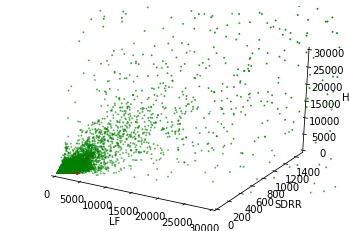

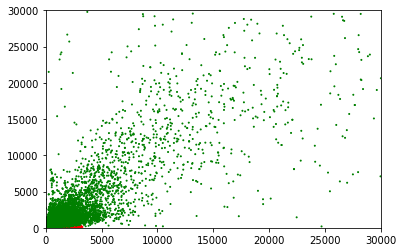

In [ ]:

colormap = np.array(['r', 'r', 'r', 'g'])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(yc, xc, zc, s=1, c=colormap[color_i])
ax.set_xlabel("LF"); ax.set_ylabel("SDRR"); ax.set_zlabel("HF")
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlim3d(0,30000)
ax.set_ylim3d(0,1500)
ax.set_zlim3d(0,30000)
plt.show()
plt.scatter(yc, zc, s=1, c=colormap[color_i])
plt.xlim(0,30000)
plt.ylim(0,30000)
plt.show()

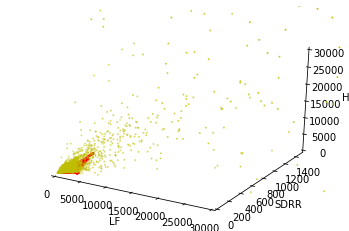

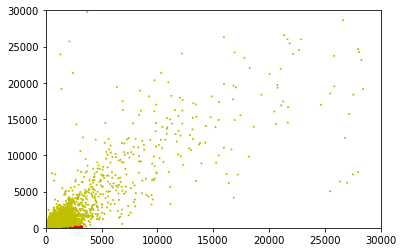

In [ ]:
colormap = np.array(['r', 'r', 'r', 'y'])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(yc5, xc5, zc5, s=1, c=colormap[color5_i])
ax.set_xlabel("LF"); ax.set_ylabel("SDRR"); ax.set_zlabel("HF")
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlim3d(0,30000)
ax.set_ylim3d(0,1500)
ax.set_zlim3d(0,30000)
plt.show()
plt.scatter(yc5, zc5, s=1, c=colormap[color5_i])
plt.xlim(0,30000)
plt.ylim(0,30000)
plt.show()

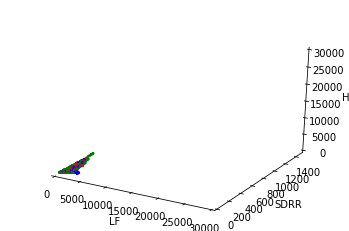

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(yc_X_test_new, xc_X_test_new, zc_X_test_new, s=1, c=colormap[y_test])
ax.set_xlabel("LF"); ax.set_ylabel("SDRR"); ax.set_zlabel("HF")
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlim3d(0,30000)
ax.set_ylim3d(0,1500)
ax.set_zlim3d(0,30000)
plt.show()

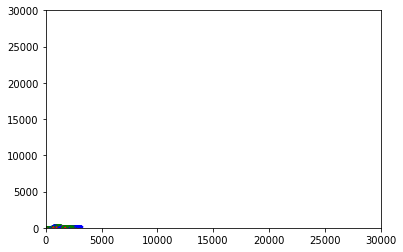

In [ ]:
plt.scatter(yc_X_test_new, zc_X_test_new, s=1, c=colormap[y_test])
plt.xlim(0,30000)
plt.ylim(0,30000)
plt.show()

In [ ]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')

#ax.scatter(test_yc, test_xc, test_zc, s=1, c=colormap[y_test])
#plt.show()

In [ ]:
#X_train_mixed = np.concatenate((X_train_new, PA_train),axis=0)
#y_train_mixed = np.concatenate((y_train, y_unlabeled), axis=0)
#print(X_train_new.shape)
#print(PA_train.shape)
#print(X_train_mixed.shape)
#print(y_train.shape)
#print(y_unlabeled.shape)
#print(y_train_mixed.shape)

(369289, 14)
(37026, 14)
(406315, 14)
(369289,)
(37026,)
(406315,)


In [ ]:
#label_prop_model = LabelSpreading(kernel='knn', n_neighbors=100, max_iter=30, n_jobs=-1)
#label_prop_model.fit(X_train_mixed, y_train_mixed)

LabelSpreading(kernel='knn', n_jobs=-1, n_neighbors=100)

In [ ]:
#pd.DataFrame(label_prop_model.transduction_[-y_unlabeled.size:]).to_csv("/content/drive/MyDrive/SWELL/hrv PA/swell_label_transduction_to_PA_knn100.csv")

In [ ]:
#label_prop_model = LabelSpreading(kernel='knn', n_neighbors=10, max_iter=30, n_jobs=-1)
#label_prop_model.fit(X_train_mixed, y_train_mixed)

LabelSpreading(kernel='knn', n_jobs=-1, n_neighbors=10)

In [ ]:
#pd.DataFrame(label_prop_model.transduction_[-y_unlabeled.size:]).to_csv("/content/drive/MyDrive/SWELL/hrv PA/swell_label_transduction_to_PA_knn10.csv")

In [ ]:
#label_prop_model = LabelSpreading(kernel='knn', n_neighbors=7, max_iter=30, n_jobs=-1)
#label_prop_model.fit(X_train_mixed, y_train_mixed)

LabelSpreading(kernel='knn', n_jobs=-1)

In [ ]:
#pd.DataFrame(label_prop_model.transduction_[-y_unlabeled.size:]).to_csv("/content/drive/MyDrive/SWELL/hrv PA/swell_label_transduction_to_PA_knn7.csv")

In [ ]:
# Random Forest Model
RFC = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='sqrt', n_jobs=-1)

In [ ]:
RFC.fit(XPA_train, yPA_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt', n_jobs=-1)

In [ ]:
RFC.score(X_test_new, np.full(y_test.size, 5))

0.631637949942729

In [ ]:
RFC_cf=confusion_matrix(np.full(y_test.size, 5), RFC.predict(X_test_new))
print(RFC_cf)

[[    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [  822  1039   897 12357 25918]]


In [ ]:
import time

start_time = time.time()
importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.104 seconds


['MEAN_RR', 'SDRR', 'HR', 'VLF', 'VLF%', 'LF', 'LF%', 'LF norm%', 'HF', 'HF%', 'HF norm%', 'TP', 'LF/HF', 'HF/LF']


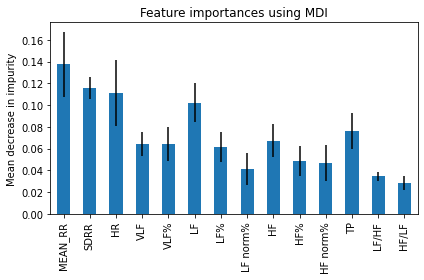

In [ ]:
#feature_names = [f"feature {i}" for i in range(X_train_new.shape[1])]
feature_names = ["MEAN_RR", "SDRR", "HR", "VLF", "VLF%", "LF", "LF%", "LF norm%", "HF", "HF%", "HF norm%", "TP", "LF/HF", "HF/LF"]
print(feature_names)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(RFC, X_test_new, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 10.259 seconds


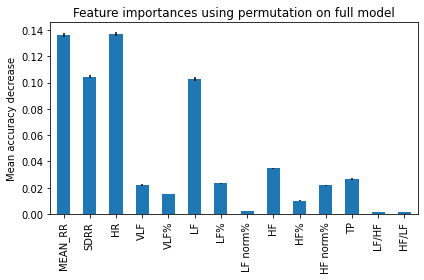

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
#Adaboost model
# Instantiate dt
DTC = DecisionTreeClassifier(max_depth=2, random_state=1)
# Instantiate ada
ADA = AdaBoostClassifier(base_estimator=DTC, n_estimators=100, random_state=1)
ADA.fit(X_train_new, y_train)

In [ ]:
y_pred_proba = ADA.predict_proba(X_test_new)

In [ ]:
#ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
#print('ROC AUC score: {:.2f}'.format(ada_roc_auc))
ADA.score(X_test_new, y_test)

In [ ]:
ADA_y_predict = ADA.predict(X_test_new)
ADA_cf=confusion_matrix(y_test, ADA_y_predict)
print(metrics.classification_report(y_test, ADA_y_predict))

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, ADA_y_predict, display_labels=ADA.classes_, 
                                                normalize=None, cmap=plt.cm.Blues)
plt.show()

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, ADA_y_predict, display_labels=ADA.classes_, 
                                                normalize='true', cmap=plt.cm.Blues)
plt.show()

In [ ]:
#xgb model
XGB = XGBClassifier()

In [ ]:
#fit the model
XGB.fit(X_train_new, y_train)

In [ ]:
XGB.score(X_test_new, y_test)

In [ ]:
XGB_y_predict = XGB.predict(X_test_new)
XGB_cf=confusion_matrix(y_test, XGB_y_predict)
print(metrics.classification_report(y_test, XGB_y_predict))

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, XGB_y_predict, display_labels=XGB.classes_, 
                                                normalize=None, cmap=plt.cm.Blues)
plt.show()

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, XGB_y_predict, display_labels=XGB.classes_, 
                                                normalize='true', cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Multi-layer NN model 20 hidden layers 300 nodes
#MLPC = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20, 300), 
#                     max_iter=10000, early_stopping=True, random_state=42)

In [ ]:
#MLPC.fit(X_train_new, y_train)

In [ ]:
#MLPC.score(X_test_new, y_test)

In [ ]:
#MLPC_y_predict = MLPC.predict(X_test_new)
#MLPC_cf=confusion_matrix(y_test, MLPC_y_predict)
#print(metrics.classification_report(y_test, MLPC_y_predict))

In [ ]:
#metrics.ConfusionMatrixDisplay.from_predictions(y_test, MLPC_y_predict, display_labels=MLPC.classes_, 
#                                                normalize=None, cmap=plt.cm.Blues)
#plt.show()

In [ ]:
#metrics.ConfusionMatrixDisplay.from_predictions(y_test, MLPC_y_predict, display_labels=MLPC.classes_, 
#                                                normalize='true', cmap=plt.cm.Blues)
#plt.show()

In [ ]:
#Multi-layer NN model 20 hidden layers 200 nodes
#MLPC = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20, 200), 
#                     max_iter=10000, early_stopping=True, random_state=42)

In [ ]:
#MLPC.fit(X_train_new, y_train)

In [ ]:
#MLPC.score(X_test_new, y_test)

In [ ]:
#MLPC_y_predict = MLPC.predict(X_test_new)
#MLPC_cf=confusion_matrix(y_test, MLPC_y_predict)
#print(metrics.classification_report(y_test, MLPC_y_predict))
#print(MLPC_cf)

In [ ]:
#Multi-layer NN model 10 hidden layers 200 nodes
MLPC = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20, 200), 
                     max_iter=10000, early_stopping=True, random_state=42)

In [ ]:
MLPC.fit(X_train_new, y_train)

In [ ]:
MLPC.score(X_test_new, y_test)

In [ ]:
MLPC_y_predict = MLPC.predict(X_test_new)
MLPC_cf=confusion_matrix(y_test, MLPC_y_predict)
print(metrics.classification_report(y_test, MLPC_y_predict))
print(MLPC_cf)

In [ ]:
#Multi-layer NN model 20 hidden layers 100 nodes each
MLPC = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20, 200), 
                     max_iter=10000, early_stopping=True, random_state=42)

In [ ]:
MLPC.fit(X_train_new, y_train)

In [ ]:
MLPC.score(X_test_new, y_test)

In [ ]:
MLPC_y_predict = MLPC.predict(X_test_new)
MLPC_cf=confusion_matrix(y_test, MLPC_y_predict)
print(metrics.classification_report(y_test, MLPC_y_predict))

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, MLPC_y_predict, display_labels=MLPC.classes_, 
                                                normalize=None, cmap=plt.cm.Blues)
plt.show()

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, MLPC_y_predict, display_labels=MLPC.classes_, 
                                                normalize='true', cmap=plt.cm.Blues)
plt.show()

In [ ]:
# K-nn model k=10

KNC = KNeighborsClassifier(n_neighbors=7)
KNC.fit(X_train_new, y_train)

In [ ]:
KNC.score(X_test_new, y_test)

In [ ]:
KNC_y_predict = KNC.predict(X_test_new)
KNC_cf=confusion_matrix(y_test, KNC_y_predict)
print(metrics.classification_report(y_test, KNC_y_predict))

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, KNC_y_predict, display_labels=KNC.classes_, 
                                                normalize=None, cmap=plt.cm.Blues)
plt.show()

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, KNC_y_predict, display_labels=KNC.classes_, 
                                                normalize='true', cmap=plt.cm.Blues)
plt.show()

In [ ]:
# confusion matrix examples
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
cf=[[5/62, 38/62, 19/62],[12/200, 44/200, 144/200],[0/376, 40/376, 336/376]]
sn.heatmap(cf, annot=True, cmap='flare')
plt.show()

In [ ]:
# SVC self_training
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_new)
#X_test_scaled = scaler.transform(X_test_new)
#svm = SVC()
#svm.fit(X_train_scaled, y_train)

#new methods
#svc_model = SVC(kernel='rbf', 
#            probability=True, 
#            C=1.0, # default = 1.0
#            gamma='scale', # default = 'scale'
#            random_state=0
#           )
#SVCC = svc_model.fit(X_train_new, y_train)

In [ ]:
#svc_y_predict = svc_model.predict(X_test_new)
#svc_model.score(X_test_new, y_test)
#print(metrics.classification_report(y_test, svc_y_predict))

In [ ]:
#svc_cf=confusion_matrix(y_test, svc_y_predict)

In [ ]:
#metrics.ConfusionMatrixDisplay.from_predictions(y_test, svc_y_predict, display_labels=svm.classes_, 
#                                                normalize=None, cmap=plt.cm.Blues)
#plt.show()

In [ ]:
#metrics.ConfusionMatrixDisplay.from_predictions(y_test, svc_y_predict, display_labels=svm.classes_, 
#                                                normalize='true', cmap=plt.cm.Blues)
#plt.show()

In [ ]:
#SVC_sleep_predict = svm.predict(HRV_P1_test)
#pd.DataFrame(SVC_sleep_predict).to_csv("/content/drive/MyDrive/SWELL/hrv sleep/SVC_predict_P1.csv")
#SVC_sleep_predict = svm.predict(HRV_P2_test)
#pd.DataFrame(SVC_sleep_predict).to_csv("/content/drive/MyDrive/SWELL/hrv sleep/SVC_predict_P2.csv")
#SVC_sleep_predict = svm.predict(HRV_P3_test)
#pd.DataFrame(SVC_sleep_predict).to_csv("/content/drive/MyDrive/SWELL/hrv sleep/SVC_predict_P3.csv")